In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from model import PINN
from SLoader import SLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/mn/stornext/d8/data/dennisfr/PINN/S-Star-PINN/SLoader.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u = torch.tensor(self.u, dtype=torch.float32)


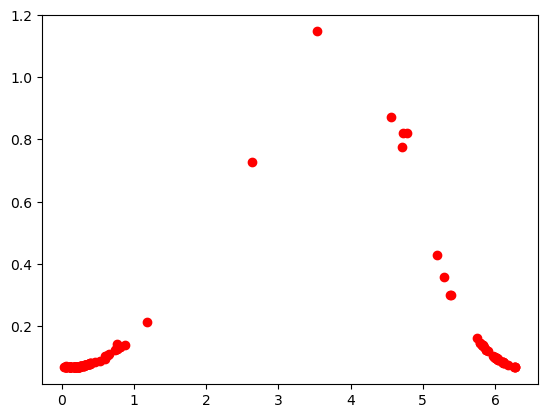

In [148]:
scaling = 1e-2
S2 = SLoader(files=["data/astrometry_NACO.csv", "data/astrometry_SHARP.csv"], scaling=scaling, std_data=True)
#d = SLoader(files=["data/astrometry_NACO.csv"])
x = S2.phi
y = S2.u

fig, ax = plt.subplots()
ax.plot(x,y, 'ro')



In [149]:
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        #self.e_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        #self.mu_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        #self.M_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        #self.phi0_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))

        self.e_ = torch.nn.Parameter(torch.tensor(0.88))
        self.mu_ = torch.nn.Parameter(torch.tensor(1.8e-2))
        self.M_ = torch.nn.Parameter(torch.tensor(0.04))
        self.phi0_ = torch.nn.Parameter(torch.tensor(3.14))
 
        # Enable gradient for trainable parameters
        self.e_requires_grad = True
        self.mu_.requires_grad = True
        self.M_.requires_grad = True
        self.phi0_.requires_grad = True
    
    def get_mu(self):
        return torch.abs(self.mu_)

    def get_e(self):
        return torch.abs(self.e_)

    def get_M(self):
        return torch.abs(self.M_) 
    
    def get_phi0(self):
        return self.phi0_
 
    def forward(self, x):
        mu = self.get_mu()
        e  = self.get_e()
        M  = self.get_M()
        phi0 = self.get_phi0()

        u = mu/M * (1 + e*torch.cos(x + phi0))
        return u


In [150]:
# Initialize model
lr = 1e-4

model = SNN()
optimizer = optim.Adam(lr=lr, params=model.parameters())
#criterion = nn.MSELoss()
criterion = nn.L1Loss()

losses = []
params = [[], [], [], []]

In [155]:
epochs = 10_000

for epoch in tqdm(range(epochs)):
    phi, u = S2()
    
    out = model(phi)
    #loss = criterion(out, u)
    loss = criterion(1/out, 1/u)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.cpu().detach().numpy())

    params[0].append(model.get_e().item())
    params[1].append(model.get_mu().item())
    params[2].append(model.get_M().item())
    params[3].append(model.get_phi0().item())


100%|██████████| 10000/10000 [00:12<00:00, 812.99it/s]


In [156]:

print("\n===== S2 =====")
print("e =", model.get_e().item())
print("p =", model.get_M().item()/model.get_mu().item())
#print("p =", model.S2.get_p().item())
print("mu =", model.get_mu().item())
print("phi0 = ", model.get_phi0().item())
print("M =", model.get_M().item())


===== S2 =====
e = 0.8498323559761047
p = 2.247610999826741
mu = 0.018383581191301346
phi0 =  3.012105941772461
M = 0.041319139301776886


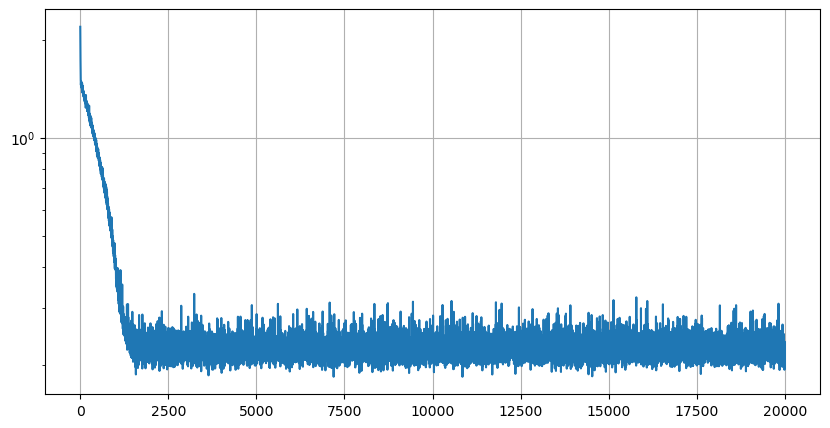

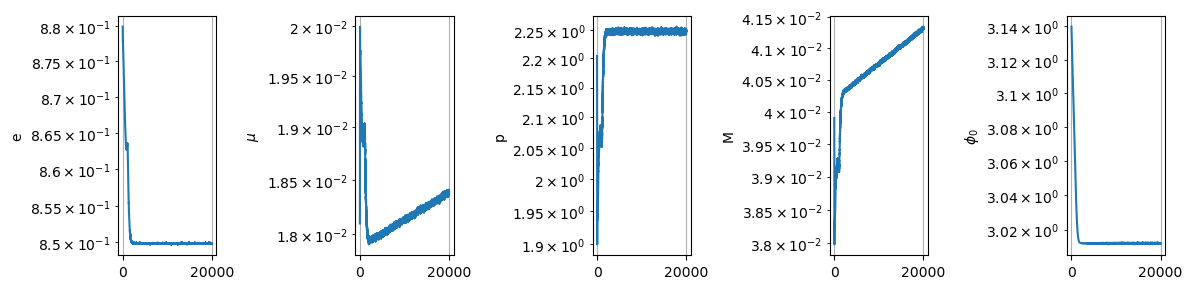

In [157]:

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(losses)
ax.grid(); ax.set_yscale("log")
plt.show()


fig, ax = plt.subplots(ncols=5, figsize=(12,3))
[axi.set_yscale("log") for axi in ax]

ax[0].plot(params[0])
ax[0].set_ylabel("e")
ax[0].grid()

ax[1].plot(params[1])
ax[1].set_ylabel(r"$\mu$")
ax[1].grid()

ax[2].plot(np.array(params[2])/np.array(params[1]))
ax[2].set_ylabel("p")
ax[2].grid()

ax[3].plot(params[2])
ax[3].set_ylabel("M")
ax[3].grid()

ax[4].plot(params[3])
ax[4].set_ylabel(r"$\phi_0$")
ax[4].grid()

plt.tight_layout()
plt.show()



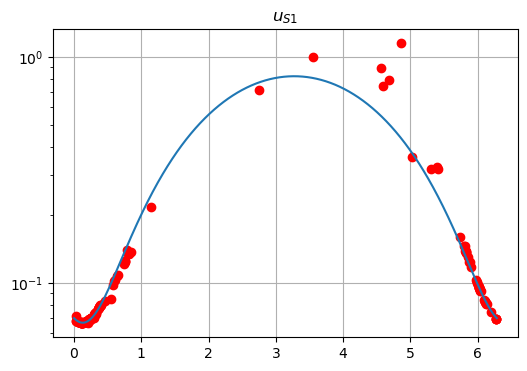

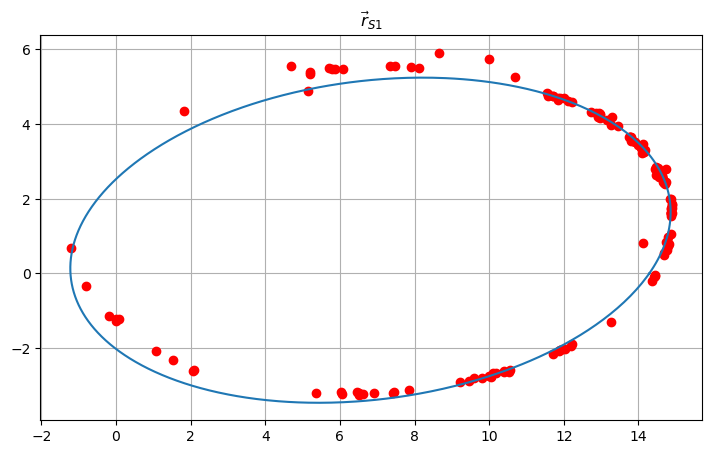

In [160]:
u_ = S2.u
phi_ = S2.phi

tphi = torch.linspace(0, 2*torch.pi, steps=1000).view(-1,1)

out = model(tphi).detach().numpy()

fig, ax = plt.subplots(figsize=(6,4))
ax.grid()
ax.set_title(r"$u_{S1}$")
ax.plot(phi, u, 'ro')
ax.plot(tphi, out)
ax.set_yscale("log")




fig, ax = plt.subplots(figsize=(10,5))
ax.grid()
ax.plot(torch.cos(phi_)/u_, torch.sin(phi_)/u_, 'ro')
ax.plot(torch.cos(tphi)/out, torch.sin(tphi)/out)
ax.set_title(r"$\vec{r}_{S1}$")
ax.set_aspect('equal')
